### Description of fer2013 dataset from Kaggle

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

In [1]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
from sklearn.metrics import classification_report

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers

In [5]:
import scikitplot
import seaborn as sns
from matplotlib import pyplot

In [6]:
from sklearn.metrics import classification_report

Data preprocessing

In [7]:
#reading the data from csv file from kaggle
data = pd.read_csv('./fer2013.csv')

width, height = 48, 48
datapoints = data['pixels'].tolist()

#getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

#getting labels for training
y = pd.get_dummies(data['emotion']).to_numpy()

#storing them using numpy
np.save('fdataX', X)
np.save('flabels', y)

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: "+ str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")

Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:35887
X,y stored in fdataX.npy and flabels.npy respectively


In [8]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 20
width, height = 48, 48

In [9]:
x = np.load('./fdataX.npy')
y = np.load('./flabels.npy')

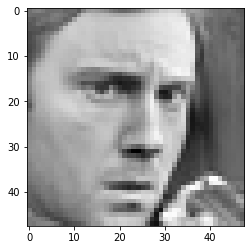

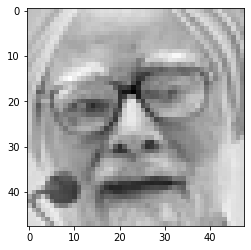

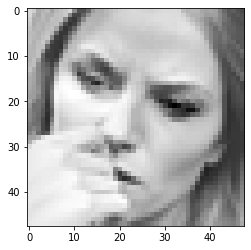

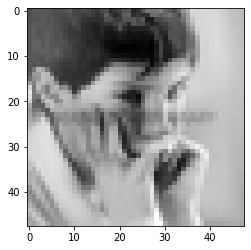

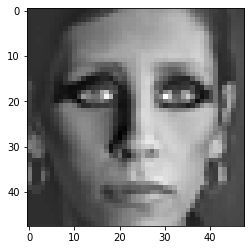

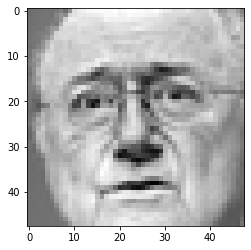

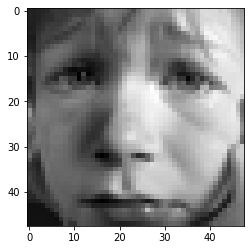

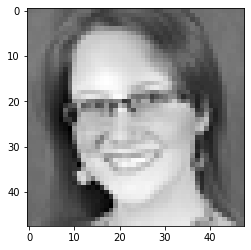

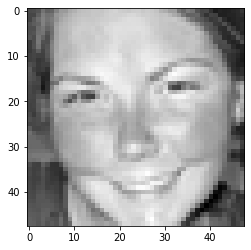

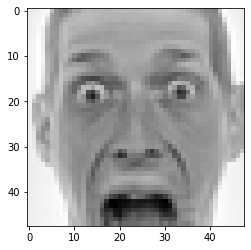

In [10]:
x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

for xx in range(10):
    pyplot.figure(xx)
    pyplot.imshow(x[xx].reshape((48, 48)), interpolation='none', cmap='gray')
    pyplot.show()

#splitting into test and train sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
#splitting train to train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

#saving the samples to be used later
np.save('modXtest', X_test)
np.save('modytest', y_test)

np.save('modXtrain', X_train)
np.save('modytrain', y_train)

np.save('modXvalid', X_valid)
np.save('modyvalid', y_valid)

Create data generator

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

Create callbacks for early stopping of training process and reducing learing rate when training is not satisfactory

In [12]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

Image dimensions

In [13]:
img_width = 48
img_height = 48
img_depth =1

### Small model

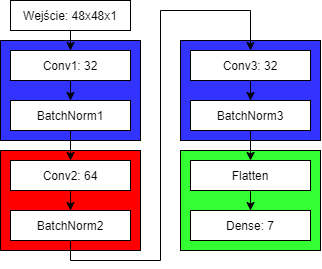

In [14]:
#create model
model = Sequential()

#add model layers
model.add(Conv2D(        
    filters=32,
    input_shape=(img_width, img_height, img_depth),
    kernel_size=(3,3),
    activation='relu',
    padding='same',
    kernel_initializer='he_normal'
))
model.add(BatchNormalization())
model.add(Conv2D(        
    filters=64,
    kernel_size=(3,3),
    activation='relu',
    padding='same',
    kernel_initializer='he_normal'
))
model.add(BatchNormalization())
model.add(Conv2D(        
    filters=32,
    kernel_size=(3,3),
    activation='relu',
    padding='same',
    kernel_initializer='he_normal'
))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(7, activation='softmax'))

In [15]:
#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [16]:
training the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

The accuracy and loss function obtained for this model: 
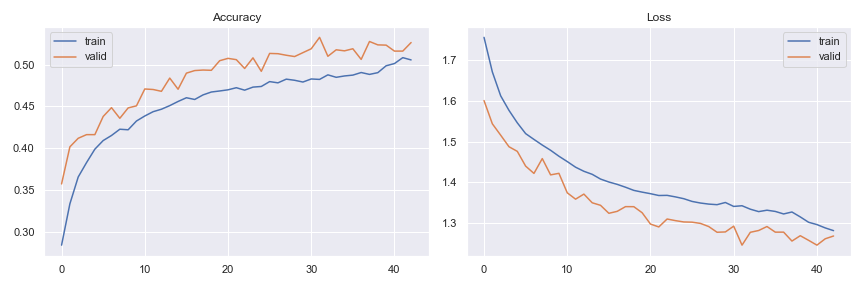

Confusion matrix: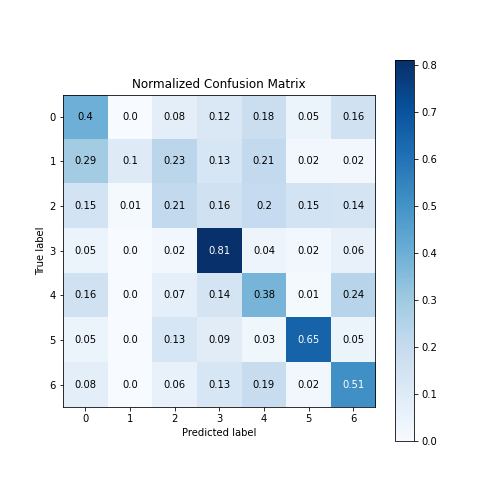

### Big model
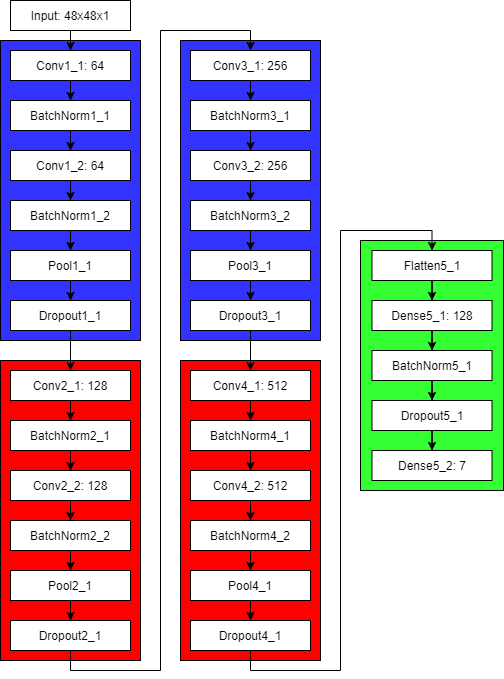

In [17]:
#create model
model2 = Sequential()


model2.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=(img_width, img_height, img_depth),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )
)
model2.add(BatchNormalization(name='batchnorm_1'))
model2.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )
)
model2.add(BatchNormalization(name='batchnorm_2'))

model2.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model2.add(Dropout(0.4, name='dropout_1'))

model2.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )
)
model2.add(BatchNormalization(name='batchnorm_3'))
model2.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )
)
model2.add(BatchNormalization(name='batchnorm_4'))

model2.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
model2.add(Dropout(0.4, name='dropout_2'))

model2.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )
)
model2.add(BatchNormalization(name='batchnorm_5'))

model2.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )
)
model2.add(BatchNormalization(name='batchnorm_6'))

model2.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model2.add(Dropout(0.5, name='dropout_3'))

model2.add(
    Conv2D(
        filters=512,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_7'
    )
)
model2.add(BatchNormalization(name='batchnorm_7'))

model2.add(
    Conv2D(
        filters=512,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_8'
    )
)
model2.add(BatchNormalization(name='batchnorm_8'))

model2.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_4'))
model2.add(Dropout(0.5, name='dropout_4'))




model2.add(Flatten(name='flatten'))

model2.add(
    Dense(
        128,
        activation='relu',
        kernel_initializer='he_normal',
        name='dense_1'
    )
)
model2.add(BatchNormalization(name='batchnorm_9'))

model2.add(Dropout(0.6, name='dropout_5'))

model2.add(
    Dense(
        7,
        activation='softmax',
        name='out_layer'
    )
)

In [18]:
#Compliling the model with adam optimixer and categorical crossentropy loss
model2.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [19]:
batch_size = 32
epochs = 100
optims = [
  optimizers.Nadam(
      learning_rate=0.001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      name='Nadam'),
    
  optimizers.Adam(0.001),
]

In [20]:
training the model
history2 = model2.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

The accuracy and loss function obtained for this model:
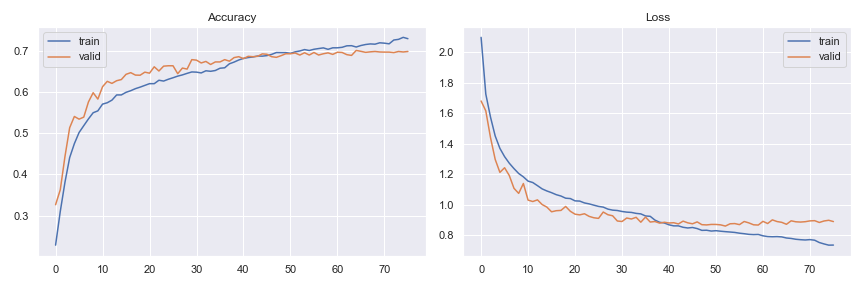

Confusion matrix:
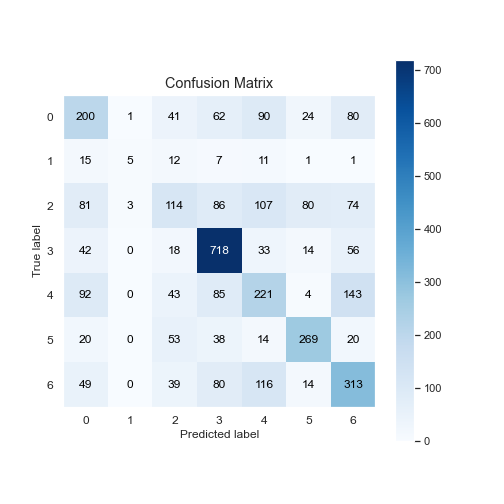

In [21]:
model2.load_weights('Duzymodel.h5')

total wrong validation predictions: 1150


              precision    recall  f1-score   support

           0       0.58      0.64      0.61       498
           1       0.60      0.56      0.58        52
           2       0.64      0.47      0.54       545
           3       0.87      0.87      0.87       881
           4       0.58      0.50      0.54       588
           5       0.77      0.74      0.76       414
           6       0.58      0.76      0.66       611

    accuracy                           0.68      3589
   macro avg       0.66      0.65      0.65      3589
weighted avg       0.68      0.68      0.68      3589



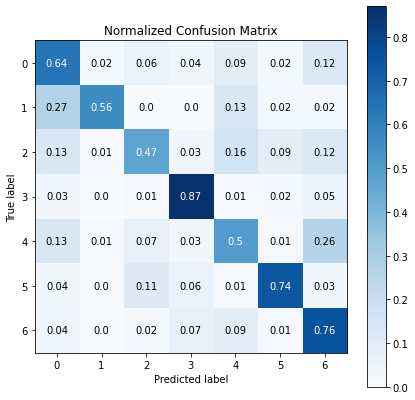

In [22]:
yhat_valid = model2.predict_classes(X_test)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_valid, figsize=(7,7), normalize=True)

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), yhat_valid))

# ANOTHER IDEA: use pretrained VGG16 and see how it performs


In [21]:
from tensorflow.keras.applications import VGG16

issue with using pretrained VGG model is need to use all 3 channels due to its training on colored images so to achive that in this case I will duplicate grayscale object 3 times.

In [22]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

In [23]:
X_train_duppedx3 = np.concatenate((X_train,)*3, axis=-1) 
y_train_duppedx3 = np.concatenate((y_train,)*3, axis=-1) 
X_valid_duppedx3 = np.concatenate((X_valid,)*3, axis=-1) 
y_valid_duppedx3 = np.concatenate((y_valid,)*3, axis=-1) 

In [24]:
print(X_train_duppedx3.shape)
print(y_train_duppedx3.shape)
print(X_valid_duppedx3.shape)
print(y_valid_duppedx3.shape)

(29068, 48, 48, 3)
(29068, 21)
(3230, 48, 48, 3)
(3230, 21)


We had problems with fitting the model because i dupped not only the data but also the labels and was trying to use "y_train_duppedx3" with 21 outputs insted of 7

In [29]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [28]:
early_stopping = EarlyStopping(
    monitor='val_acc',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [30]:
X_test_duppedx3 = np.concatenate((X_test,)*3, axis=-1) 
y_test_duppedx3 = np.concatenate((y_test,)*3, axis=-1) 

In [30]:
model3 = Sequential()
model3.add(conv_base)
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(7, activation='sigmoid'))

In [31]:
model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [32]:
history3 = model3.fit(
    train_datagen.flow(X_train_duppedx3, y_train, batch_size=batch_size),
    validation_data=(X_valid_duppedx3, y_valid),
    steps_per_epoch=len(X_train_duppedx3) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
908/908 [==============================] - 271s 297ms/step - loss: 0.3774 - acc: 0.3326 - val_loss: 0.3269 - val_acc: 0.4387
Epoch 2/100
908/908 [==============================] - 252s 277ms/step - loss: 0.3428 - acc: 0.4077 - val_loss: 0.3135 - val_acc: 0.4678
Epoch 3/100
908/908 [==============================] - 249s 274ms/step - loss: 0.3306 - acc: 0.4334 - val_loss: 0.3011 - val_acc: 0.4916
Epoch 4/100
908/908 [==============================] - 248s 273ms/step - loss: 0.3205 - acc: 0.4548 - val_loss: 0.2983 - val_acc: 0.4901
Epoch 5/100
908/908 [==============================] - 249s 274ms/step - loss: 0.3147 - acc: 0.4660 - val_loss: 0.2938 - val_acc: 0.5130
Epoch 6/100
908/908 [==============================] - 248s 273ms/step - loss: 0.3091 - acc: 0.4792 - val_loss: 0.2892 - val_acc: 0.5090
Epoch 7/100
908/908 [==============================] - 248s 273ms/step - loss: 0.3044 - acc: 0.4881 - val_loss: 0.2820 - val_acc: 0.5189
Epoch 8/100
908/908 [====================

Epoch 60/100
908/908 [==============================] - 258s 284ms/step - loss: 0.2102 - acc: 0.6785 - val_loss: 0.2654 - val_acc: 0.5981
Epoch 61/100
908/908 [==============================] - 258s 284ms/step - loss: 0.2100 - acc: 0.6789 - val_loss: 0.2599 - val_acc: 0.5981
Epoch 62/100
908/908 [==============================] - 258s 284ms/step - loss: 0.2095 - acc: 0.6773 - val_loss: 0.2671 - val_acc: 0.5997
Epoch 63/100
908/908 [==============================] - 258s 284ms/step - loss: 0.2085 - acc: 0.6778 - val_loss: 0.2633 - val_acc: 0.5957
Epoch 64/100
908/908 [==============================] - 258s 284ms/step - loss: 0.2068 - acc: 0.6833 - val_loss: 0.2660 - val_acc: 0.5969
Epoch 65/100
908/908 [==============================] - 257s 283ms/step - loss: 0.2064 - acc: 0.6844 - val_loss: 0.2624 - val_acc: 0.5975

Epoch 00065: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
Epoch 66/100
908/908 [==============================] - 258s 284ms/step - loss: 0.2036 - ac

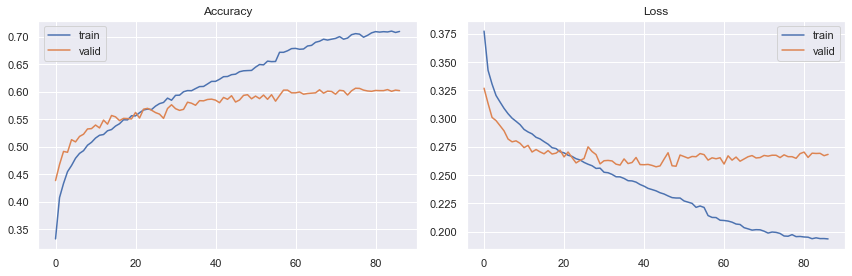

In [33]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history3.epoch, history3.history['acc'], label='train')
sns.lineplot(history3.epoch, history3.history['val_acc'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history3.epoch, history3.history['loss'], label='train')
sns.lineplot(history3.epoch, history3.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_transfer_learning.png')
pyplot.show()

#### Usage of smaller Dropout is helpful but now we can see overfitting of the model

### Maybe this specific data is troublesome for cnns to work on.

That is also covered by the authors of the dataset. They state that even humans had trouble with categorising emotions on photos they provided. They say that we can achive accuracy around 65 +/- 5%. Having this in mind the models provided in this project all behave almost similart to what we could exspect from humans. Therefore We are satisfied with the results we obtained.